# Fig. S5B
low mag widefield time series analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage.io import imread
from glob import glob
from functools import partial

In [2]:
#%matplotlib qt
%matplotlib inline

In [3]:
"""plot style"""
linewidth = 4
mpl.rc('axes', linewidth=linewidth)
mpl.rc('font', family='Arial')
fontsize = 24


colors = {'no_inj': [0.8, 0.8, 0.8],
         'mock': [0.4, 0.4, 0.4],
         'e.coli': [0, 0.4, 0],
         'complete': [0, 0.8, 0]}

def style_axes(ax, fontsize=24):
    plt.minorticks_off()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_tick_params(labelsize=20)
    ax.yaxis.set_tick_params(labelsize=20)
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    plt.tight_layout()
    
    return ax


In [4]:
def load_green_ims(im_dir):
    files = sorted(glob(im_dir + '/*.tif'))
    counter = 0
    for i in range(1, len(files), 2):
        im = imread(files[i])
        if counter == 0:
            im_stack = np.zeros((int(len(files) // 2), im.shape[0], im.shape[1]))
        im_stack[counter] = im
        counter += 1
    
    return im_stack
    

def load_masks(mask_dir):
    files = sorted(glob(mask_dir + '/*.tif'))
    for i in range(len(files)):
        im = imread(files[i])
        if i == 0:
            im_stack = np.zeros((len(files), im.shape[0], im.shape[1]))
        im_stack[i] = im / 255
    
    return im_stack
    

def compute_masked_pixel_stats(im_dir, fun):
    im_stack = load_green_ims(im_dir)
    anterior_mask_dir = glob(im_dir + '/*Anterior*')[0]
    anterior_mask_stack = load_masks(anterior_mask_dir)
    middle_mask_dir = glob(im_dir + '/*Middle*')[0]
    middle_mask_stack = load_masks(middle_mask_dir)
    
    assert len(im_stack) == len(anterior_mask_stack)
    assert len(im_stack) == len(middle_mask_stack)
    
    fun_arr_anterior = np.zeros(im_stack.shape[0])
    fun_arr_middle = np.zeros(im_stack.shape[0])
    for i in range(len(im_stack)):
        # anterior
        mask = anterior_mask_stack[i]
        masked_im = im_stack[i] * mask
        masked_pixels = masked_im[masked_im > 0]
        fun_arr_anterior[i] = fun(masked_pixels)
        
        # posterior
        mask = middle_mask_stack[i]
        masked_im = im_stack[i] * mask
        masked_pixels = masked_im[masked_im > 0]
        fun_arr_middle[i] = fun(masked_pixels)
    
    return fun_arr_anterior, fun_arr_middle
        

def thresholded_mean(x, thresh):
    return np.mean(x[x > thresh])




In [5]:
experiment_dir = r'/media/brandon/Data1/Tiffany/AxioZoom/With_Masks_2024_2_11_UAS-MCD8-Mcherry_r4-GAL4 X dpt-gfp_ecoli-hs-dtom_6hrtimelapse_mag23.5_exp10ms_100fluorescence'
time_points = ['2.5hr RedGreen', '3hr RedGreen', '4hr RedGreen', '5hr RedGreen', '6hr RedGreen attempt 1']
#fun = np.mean
fun = partial(thresholded_mean, thresh=200)
#fun = np.max
fun_list_ant = []
fun_list_mid= []
for t in time_points:
    im_dir = experiment_dir + '/' + t
    fun_arr_anterior, fun_arr_middle = compute_masked_pixel_stats(im_dir, fun)
    fun_list_ant.append(fun_arr_anterior)
    fun_list_mid.append(fun_arr_middle)

mean_fun_ant = [np.mean(arr) for arr in fun_list_ant]
mean_fun_mid = [np.mean(arr) for arr in fun_list_mid]
std_fun_ant = [np.std(arr) for arr in fun_list_ant]
std_fun_mid = [np.std(arr) for arr in fun_list_mid]




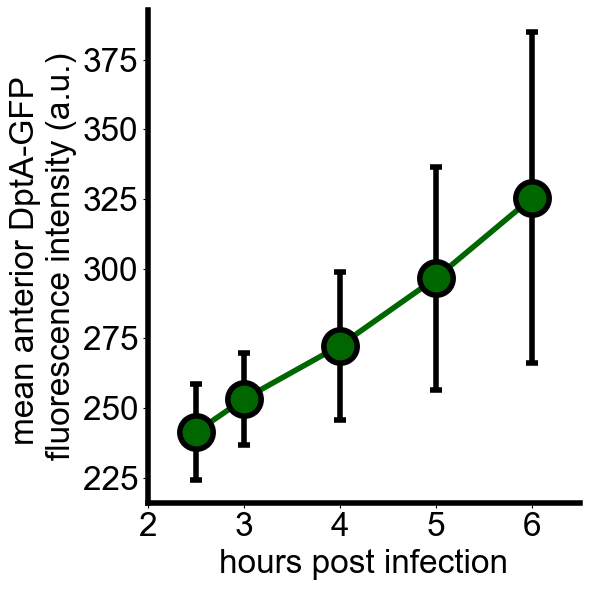

In [6]:
times = [2.5, 3, 4, 5, 6]
plt.figure(figsize=(6,6))
plt.errorbar(np.array(times), np.array(mean_fun_ant), np.array(std_fun_ant), linewidth=linewidth, ecolor='k',
             color=colors['e.coli'], capsize=4, marker='o', markersize=24, markeredgecolor='k', markeredgewidth=4)

plt.xlabel('hours post infection', fontsize=fontsize)
plt.ylabel('mean anterior DptA-GFP \nfluorescence intensity (a.u.)', fontsize=fontsize)
plt.xlim([2.0, 6.5])
ax = style_axes(plt.gca())


In [76]:
#plt.savefig(r'/home/brandon/Documents/Code/diptericin-paper/figures/low_mag_timeseries/low_mag_timeseries_anterior_vs_time.pdf')